In [1]:
import sys
import numpy as np
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/')
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *
import time

# for debugging
import scipy.interpolate

Detected 16 CPU's. Setting n_jobs to #CPU/2.


# Testing display_content()


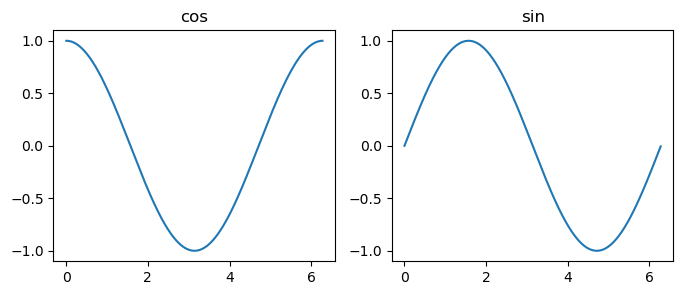

In [2]:
content1 = np.array([
    np.sin(points), # sin component
    np.cos(points) # cos component
])

ChiPhiFunc(content1, fourier_mode = True).display_content()

# Defining test variables

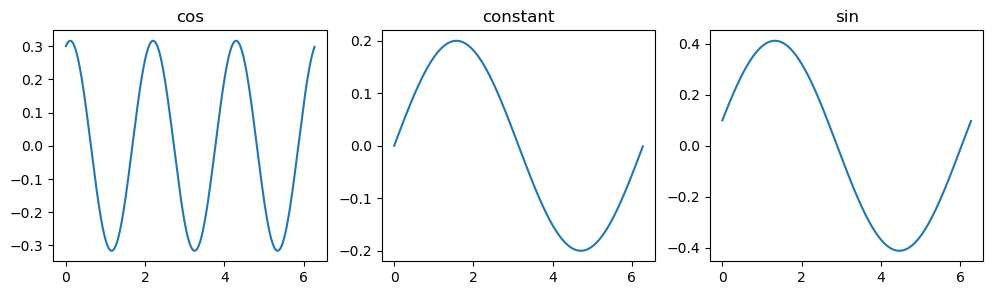

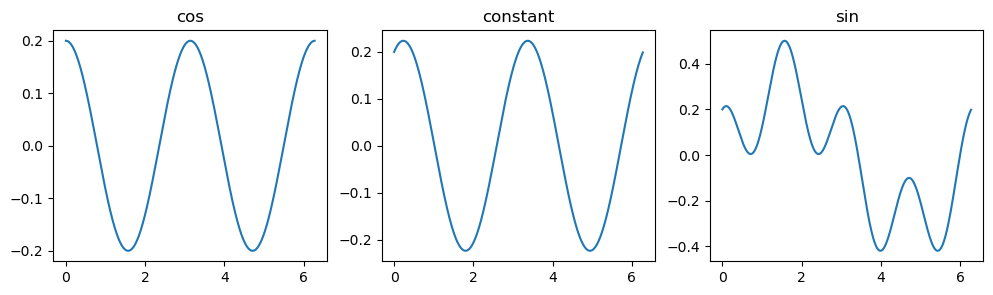

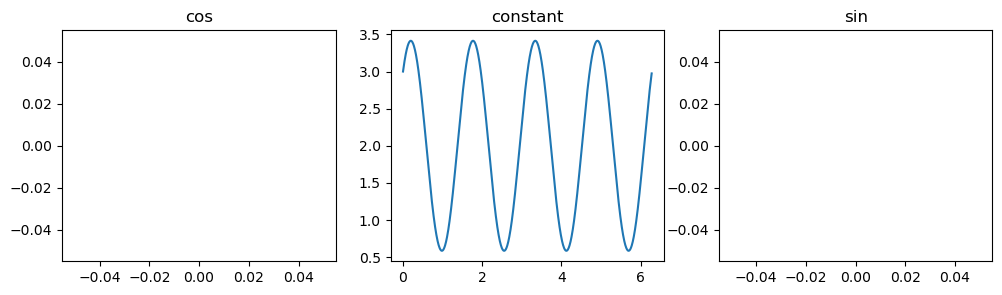

In [3]:
# Generating 2 random test cases and answers

# Creating 2 random ChiPhiFunc's for testing
rands1 = np.random.randint(5, size=12)
func1 = np.vectorize(lambda chi, phi : \
    (rands1[0]/10*np.sin(rands1[1]*phi) + rands1[2]/10*np.cos(rands1[3]*phi))*np.sin(2*chi)+\
    rands1[4]/10*np.sin(rands1[5]*phi) + rands1[6]/10*np.cos(rands1[7]*phi)+\
    (rands1[8]/10*np.sin(rands1[9]*phi) + rands1[10]/10*np.cos(rands1[11]*phi))*np.cos(2*chi))

content1 = np.array([
    rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points)
])


rands2 = np.random.randint(5, size=12)
func2 = np.vectorize(lambda chi, phi : \
    (rands2[0]/10*np.sin(rands2[1]*phi) + rands2[2]/10*np.cos(rands2[3]*phi))*np.sin(2*chi)+\
    rands2[4]/10*np.sin(rands2[5]*phi) + rands2[6]/10*np.cos(rands2[7]*phi)+\
    (rands2[8]/10*np.sin(rands2[9]*phi) + rands2[10]/10*np.cos(rands2[11]*phi))*np.cos(2*chi))
content2 = np.array([
    rands2[0]/10*np.sin(rands2[1]*points) + rands2[2]/10*np.cos(rands2[3]*points),
    rands2[4]/10*np.sin(rands2[5]*points) + rands2[6]/10*np.cos(rands2[7]*points),
    rands2[8]/10*np.sin(rands2[9]*points) + rands2[10]/10*np.cos(rands2[11]*points)
])

randsodd = np.random.randint(5, size=16)
funcodd = np.vectorize(lambda chi, phi : \
    (randsodd[0]/10*np.sin(randsodd[1]*phi) + randsodd[2]/10*np.cos(randsodd[3]*phi))*np.sin(3*chi)+\
    (randsodd[4]/10*np.sin(randsodd[5]*phi) + randsodd[6]/10*np.cos(randsodd[7]*phi))*np.sin(1*chi)+\
    (randsodd[8]/10*np.sin(randsodd[9]*phi) + randsodd[10]/10*np.cos(randsodd[11]*phi))*np.cos(1*chi)+\
    (randsodd[12]/10*np.sin(randsodd[13]*phi) + randsodd[14]/10*np.cos(randsodd[15]*phi))*np.cos(3*chi))
contentodd = np.array([
    randsodd[0]/10*np.sin(randsodd[1]*points) + randsodd[2]/10*np.cos(randsodd[3]*points),
    randsodd[4]/10*np.sin(randsodd[5]*points) + randsodd[6]/10*np.cos(randsodd[7]*points),
    randsodd[8]/10*np.sin(randsodd[9]*points) + randsodd[10]/10*np.cos(randsodd[11]*points),
    randsodd[12]/10*np.sin(randsodd[13]*points) + randsodd[14]/10*np.cos(randsodd[15]*points)
])


rands3 = np.random.randint(low=1, high=5, size=2)
func_no_chi = np.vectorize(lambda chi, phi : 
    np.sin(rands3[0]*phi) + np.cos(rands3[1]*phi)+2)
content_no_chi = np.array([
    np.sin(rands3[0]*points) + np.cos(rands3[1]*points) + 2
])
test1 = ChiPhiFunc(content1, fourier_mode = True)
test2 = ChiPhiFunc(content2, fourier_mode = True)
testodd = ChiPhiFunc(contentodd, fourier_mode = True)
test_no_chi = ChiPhiFunc(content_no_chi, fourier_mode = True)

# plt.pcolormesh(chi, phi, func1_result)
# plt.show()
test1.display_content()
test2.display_content()
test_no_chi.display_content()




In [4]:
funcodd_result = evaluate(funcodd)
func1_result = evaluate(func1)
func2_result = evaluate(func2)
func_no_chi_result = evaluate(func_no_chi)

# Testing basic operations

In [5]:
print('Testing lambda:')
print_fractional_error(evaluate_ChiPhiFunc(testodd), (funcodd_result))

Testing lambda:
Error type:     Fractional      Total          
Avg:            3.250e-16       1.693e-17      
Worst:          8.8e-12         2.238e-16      
Std             1.853e-14       2.672e-17      
Total imaginary component
0.0



In [20]:
print('Testing +:')
print('Odd-odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd+testodd), (funcodd_result+funcodd_result))
print('Even-even:')
print_fractional_error(evaluate_ChiPhiFunc(test1+test2+1), (func1_result+func2_result+1))

print('Testing -:')
print_fractional_error(evaluate_ChiPhiFunc(test1-test2-test_no_chi), (func1_result-func2_result-func_no_chi_result))

print('Testing *:')
print('Odd-odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd*testodd), (funcodd_result*funcodd_result))
print('Even-even:')
print_fractional_error(evaluate_ChiPhiFunc(test1*test2), (func1_result*func2_result))
print('Even-odd:')
print_fractional_error(evaluate_ChiPhiFunc(test1*testodd), (func1_result*funcodd_result))

print('Testing /:')
print('Even:')
print_fractional_error(evaluate_ChiPhiFunc(test1/(test_no_chi+10)), (func1_result/(func_no_chi_result+10)))
print('Odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd/(test_no_chi+10)), (funcodd_result/(func_no_chi_result+10)))


print('Testing **:')
print_fractional_error(evaluate_ChiPhiFunc(test1**3), (func1_result*func1_result*func1_result))
print_fractional_error(evaluate_ChiPhiFunc(testodd**3), (funcodd_result*funcodd_result*funcodd_result))


Testing +:
Odd-odd:
Error type:     Fractional      Total          
Avg:            nan             4.804e-17      
Worst:          2.427e-11       4.475e-16      
Std             nan             6.396e-17      
Total imaginary component
0.0

Even-even:
Error type:     Fractional      Total          
Avg:            2.274e-16       7.465e-17      
Worst:          3.197e-12       4.441e-16      
Std             9.533e-15       9.948e-17      
Total imaginary component
0.0

Testing -:
Error type:     Fractional      Total          
Avg:            1.607e-16       1.496e-16      
Worst:          2.831e-12       8.882e-16      
Std             8.727e-15       1.953e-16      
Total imaginary component
0.0

Testing *:
Odd-odd:
Error type:     Fractional      Total          
Avg:            inf             5.627e-17      
Worst:          inf             9.996e-16      
Std             nan             7.072e-17      
Total imaginary component
0.0

Even-even:
Error type:     Fractional      Tot

## Basic operations, cumulative Error

# Testing differential and integral

## $\partial_\chi$ and $\int d\chi$

Testing dchi and ichi (even)
dchi
Difference


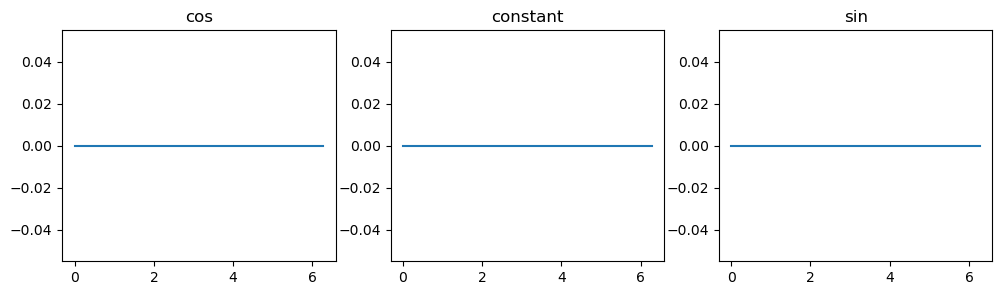

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             0.e+00         
Worst:          0.e+00          0.e+00         
Std             nan             0.e+00         
Total imaginary component
0.0

ichi
Difference


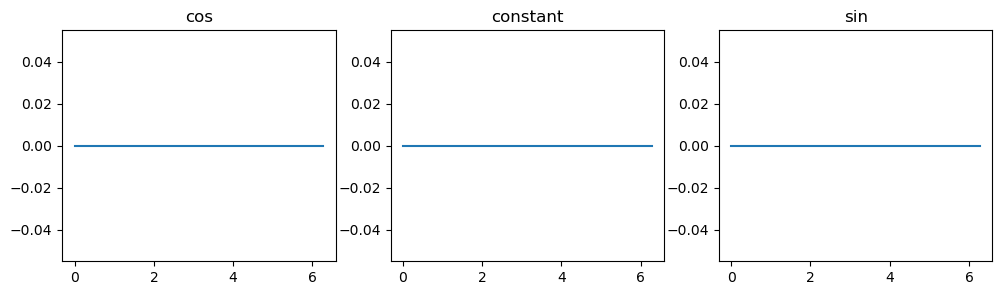

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             0.e+00         
Worst:          0.e+00          0.e+00         
Std             nan             0.e+00         
Total imaginary component
0.0



In [61]:
print('Testing dchi and ichi (even)')
rands_i = np.random.randint(1,5, size=12)
amp=0.2
test1 = amp*ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points),
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), fourier_mode = True)

test1_int = amp*ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.zeros_like(points, dtype=np.complex128),
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), fourier_mode = True)

dchi_test1 = amp*ChiPhiFunc(np.array([
        -2*(np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)), 
        np.zeros_like(points, dtype=np.complex128),
        2*(np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points))
]), fourier_mode = True)

guess_dchi = diff(test1,'chi',1)
guess_ichi = int_chi(dchi_test1)
print('dchi')
compare_chiphifunc(guess_dchi, dchi_test1)
print('ichi')
compare_chiphifunc(guess_ichi, test1_int)

Testing dchi and ichi (odd)
dchi
Difference


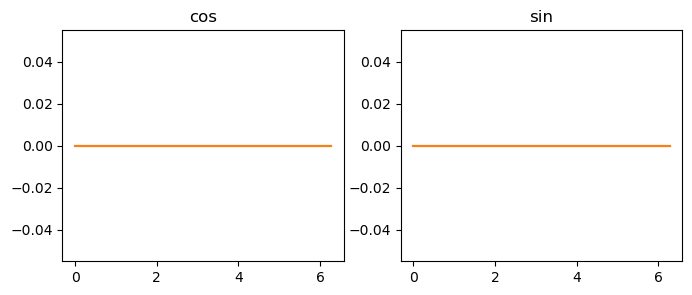

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             0.e+00         
Worst:          0.e+00          0.e+00         
Std             nan             0.e+00         
Total imaginary component
0.0

ichi
Difference


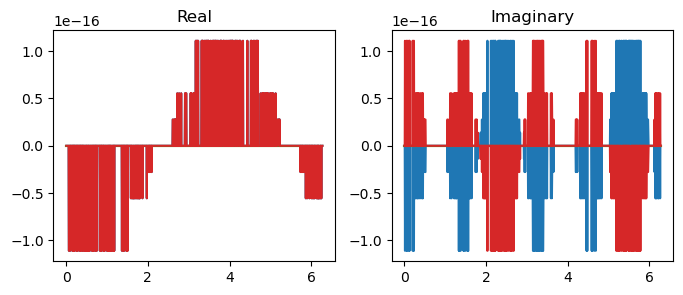

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            1.663e-17       8.701e-18      
Worst:          2.203e-16       1.110e-16      
Std             4.93e-17        2.756e-17      
Total imaginary component
0.0



In [59]:
print('Testing dchi and ichi (odd)')
rands_i = np.random.randint(1,5, size=12)


test1 = ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points), 
        np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points)
]), fourier_mode = True)

dchi_test1 = ChiPhiFunc(np.array([
        -3*(np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points)), 
        -(np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points)), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        3*(np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points))
]), fourier_mode = True)

guess_dchi = diff(test1,'chi',1)
guess_ichi = dchi_test1.integrate_chi()
print('dchi')
compare_chiphifunc(guess_dchi, dchi_test1)
print('ichi')
compare_chiphifunc(guess_ichi, test1, fourier_mode = False)

## $\partial_\phi$ and $\int d\phi$

Testing dphi
Current derivative modes: fft
Current integral modes: fft
dphi based on FFT
Difference


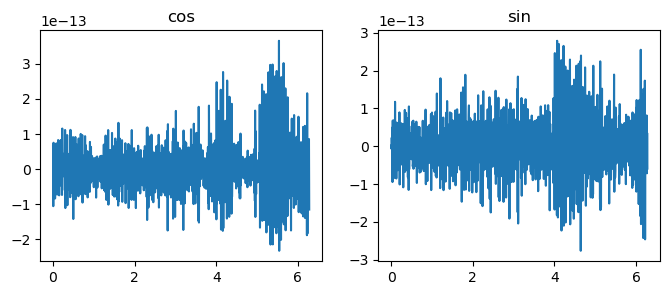

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             2.669e-14      
Worst:          inf             1.83e-13       
Std             nan             2.501e-14      
Total imaginary component
0.0

dphi based on pseudo-spectral
Difference


/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:143: RuntimeWarning: divide by zero encountered in true_divide
  frac = np.abs((guess-ans)/ans)
/Users/lanke/anaconda3/envs/nae/lib/python3.10/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


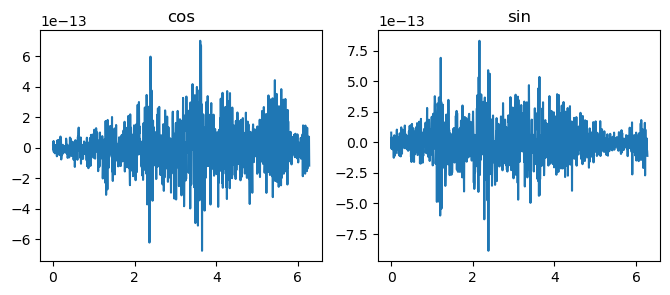

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             5.152e-14      
Worst:          inf             3.512e-13      
Std             nan             4.901e-14      
Total imaginary component
0.0

spline
Difference


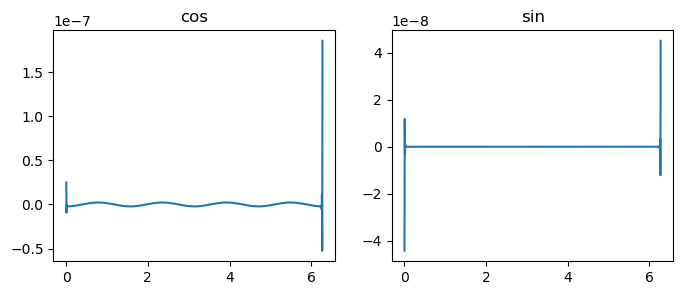

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             8.426e-10      
Worst:          inf             9.277e-08      
Std             nan             3.067e-09      
Total imaginary component
0.0



In [7]:
print('Testing dphi')
chiphifunc.diff_mode = 'fft'
print('Current derivative modes:', chiphifunc.diff_mode)
print('Current integral modes:', chiphifunc.integral_mode)
rands_i = np.random.randint(1,5, size=12)
test_diff = ChiPhiFunc(np.array([
        -1/rands_i[0]*np.cos(rands_i[0]*points) + 1/rands_i[1]*np.sin(rands_i[1]*points) +1/rands_i[0]*np.cos(0),
        -1/rands_i[2]*np.cos(rands_i[2]*points) + 1/rands_i[3]*np.sin(rands_i[3]*points) +1/rands_i[2]*np.cos(0)
]), fourier_mode = True)

ans = ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), fourier_mode = True)

guess_fft = diff(test_diff,'phi',1)
guess_pseudo_spectral = test_diff.dphi(mode = 'pseudo_spectral')
guess_spline = test_diff.dphi(mode = 'spline')
print('dphi based on FFT')
compare_chiphifunc(guess_fft, ans)
print('dphi based on pseudo-spectral')
dphi_op = dphi_op_pseudospectral(n_grid_phi)
compare_chiphifunc(guess_pseudo_spectral, ans)
print('spline')
compare_chiphifunc(guess_spline, ans)

Testing integrate_phi
Testing periodic: simpson
Error type:     Fractional      Total          
Avg:            2.066e+00       8.367e-17      
Worst:          2.191e+00       1.095e-16      
Std             8.886e-02       1.826e-17      
Total imaginary component
0.0

Testing periodic: spline
Error type:     Fractional      Total          
Avg:            4.844e+07       2.006e-09      
Worst:          6.050e+07       3.023e-09      
Std             8.530e+06       7.187e-10      
Total imaginary component
0.0

Testing general
Simpson v. ans
Difference


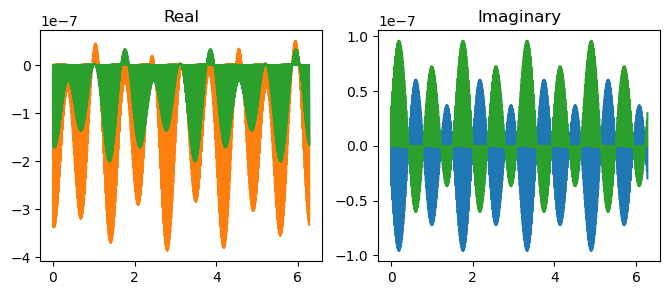

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             5.845e-08      
Worst:          1.670e+00       3.863e-07      
Std             nan             8.722e-08      
Total imaginary component
0.0

Spline v. ans
Difference


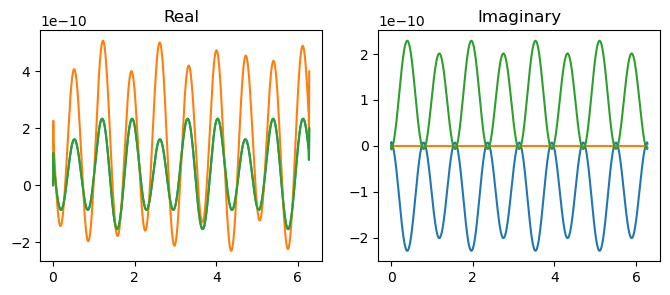

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             1.461e-10      
Worst:          8.71e+06        5.077e-10      
Std             nan             1.137e-10      
Total imaginary component
0.0

FFT v. ans
Difference


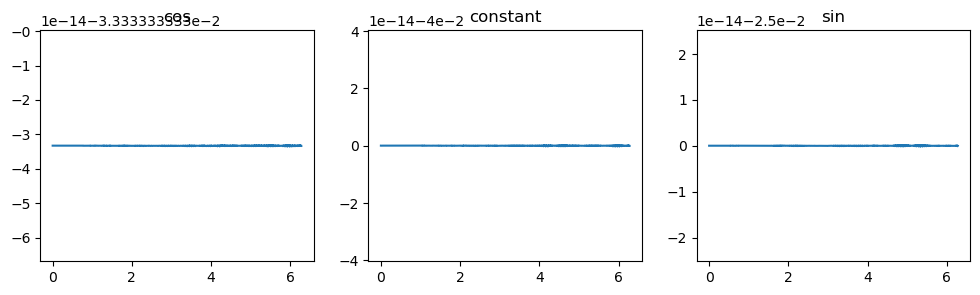

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             2.444e-02      
Worst:          inf             4.000e-02      
Std             nan             1.1e-02        
Total imaginary component
0.0



/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:143: RuntimeWarning: divide by zero encountered in true_divide
  frac = np.abs((guess-ans)/ans)
/Users/lanke/anaconda3/envs/nae/lib/python3.10/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [ ]:
print('Testing integrate_phi')
amp=0.2

rands_i = np.random.randint(1,10, size=12)
test_integral = amp*ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points)
]), fourier_mode = True)

ans = amp*ChiPhiFunc(np.array([
        -1/rands_i[0]*np.cos(rands_i[0]*points) + 1/rands_i[1]*np.sin(rands_i[1]*points) +1/rands_i[0],
        -1/rands_i[2]*np.cos(rands_i[2]*points) + 1/rands_i[3]*np.sin(rands_i[3]*points) +1/rands_i[2],
        -1/rands_i[4]*np.cos(rands_i[4]*points) + 1/rands_i[5]*np.sin(rands_i[5]*points) +1/rands_i[4]
]), fourier_mode = True)


ans_2pi = amp*ChiPhiFunc(np.array([
        [-1/rands_i[0]*np.cos(rands_i[0]*2*np.pi) + 1/rands_i[1]*np.sin(rands_i[1]*2*np.pi) +1/rands_i[0]*np.cos(0)],
        [-1/rands_i[2]*np.cos(rands_i[2]*2*np.pi) + 1/rands_i[3]*np.sin(rands_i[3]*2*np.pi) +1/rands_i[2]*np.cos(0)],
        [-1/rands_i[4]*np.cos(rands_i[4]*2*np.pi) + 1/rands_i[5]*np.sin(rands_i[5]*2*np.pi) +1/rands_i[4]*np.cos(0)]
]), fourier_mode = True)
print('Testing periodic: simpson')
print_fractional_error(test_integral.integrate_phi(periodic=True, mode = 'simpson').content,ans_2pi.content)
print('Testing periodic: spline')
print_fractional_error(test_integral.integrate_phi(periodic=True, mode = 'spline').content,ans_2pi.content)

print('Testing general')
guess = test_integral.integrate_phi(periodic=False, mode='simpson')
guess_spline = test_integral.integrate_phi(periodic=False, mode='spline')
guess_fft = test_integral.integrate_phi(periodic=False, mode='fft')

print('Simpson v. ans')
compare_chiphifunc(guess, ans, fourier_mode = False)
print('Spline v. ans')
compare_chiphifunc(guess_spline, ans, fourier_mode = False)
print('FFT v. ans')
compare_chiphifunc(guess_fft, ans)


## `diff()`

In [8]:
print('Testing diff()')
rands_i = np.random.randint(20,22, size=12)
test_diff = ChiPhiFunc(np.array([
        np.cos(rands_i[0]*points) + np.sin(rands_i[1]*points) +1/rands_i[0]*np.cos(0),
        np.cos(rands_i[2]*points) + np.sin(rands_i[3]*points) +1/rands_i[2]*np.cos(0)
]), fourier_mode = True)

ans = ChiPhiFunc(np.array([
        -rands_i[0]*np.sin(rands_i[0]*points)+rands_i[1]*np.cos(rands_i[1]*points), 
        -rands_i[2]*np.sin(rands_i[2]*points)+rands_i[3]*np.cos(rands_i[3]*points)
]), fourier_mode = True)
guess = diff(test_diff,'phi',1)
guess_fft = test_diff.dphi(mode = 'fft', order = 1)
print('dphi fft')
print_fractional_error(evaluate_ChiPhiFunc(guess_fft), evaluate_ChiPhiFunc(ans))
guess_spline = test_diff.dphi(mode = 'spline', order = 1)
print('dphi spline')
print_fractional_error(evaluate_ChiPhiFunc(guess_spline), evaluate_ChiPhiFunc(ans))
guess_finite_difference = test_diff.dphi(mode = 'finite_difference', order = 1)
print('dphi finite_difference')
print_fractional_error(evaluate_ChiPhiFunc(guess_finite_difference), evaluate_ChiPhiFunc(ans))

print('Testing dchi on chi phi array (for testing recursion relations)')
rands_i = np.random.randint(1,5, size=12)
a = np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points) 
b = np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
c = np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points) 
d = np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points) 
e = np.sin(rands_i[8]*points)+np.cos(rands_i[9]*points)
test_diff = ChiPhiFunc(np.array([a,b,c,d,e]), fourier_mode = True)

ans = ChiPhiFunc(np.array([-4*e,-2*d,np.zeros_like(c),2*b,4*a]), fourier_mode = True)

guess = diff(test_diff,'chi',1)
print('dchi')
print_fractional_error(evaluate_ChiPhiFunc(guess), evaluate_ChiPhiFunc(ans))

Testing diff()
dphi fft
Error type:     Fractional      Total          
Avg:            5.864e-05       9.329e-13      
Worst:          1.511e+01       8.427e-12      
Std             2.875e-02       1.048e-12      
Total imaginary component
0.0

dphi spline
Error type:     Fractional      Total          
Avg:            3.871e-05       4.069e-05      
Worst:          8.065e+00       1.139e-02      
Std             1.552e-02       3.088e-04      
Total imaginary component
0.0

dphi finite_difference
Error type:     Fractional      Total          
Avg:            3.571e-03       4.604e-02      
Worst:          1.150e+01       1.891e-01      
Std             5.297e-02       3.006e-02      
Total imaginary component
0.0

Testing dchi on chi phi array (for testing recursion relations)
dchi
Error type:     Fractional      Total          
Avg:            0.e+00          0.e+00         
Worst:          0.e+00          0.e+00         
Std             0.e+00          0.e+00         
Total imagi

# Testing $\phi$ ODE solvers

In [2]:
# Creating 2 random ChiPhiFunc's for testing
rands1 = np.random.randint(5, size=16)
content1 = np.array([
    rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points),
    rands1[12]/10*np.sin(rands1[13]*points) + rands1[14]/10*np.cos(rands1[15]*points)
])
test1 = ChiPhiFunc(content1, fourier_mode = True)
iota = np.random.rand()# rational: np.random.randint(1,5)/np.random.randint(1,5)
# dphi + iota*dchi
dphi_test1 = ChiPhiFunc(np.array([
    rands1[1]*rands1[0]/10*np.cos(rands1[1]*points) - rands1[3]*rands1[2]/10*np.sin(rands1[3]*points),
    rands1[5]*rands1[4]/10*np.cos(rands1[5]*points) - rands1[7]*rands1[6]/10*np.sin(rands1[7]*points),
    rands1[9]*rands1[8]/10*np.cos(rands1[9]*points) - rands1[11]*rands1[10]/10*np.sin(rands1[11]*points),
    rands1[13]*rands1[12]/10*np.cos(rands1[13]*points) - rands1[15]*rands1[14]/10*np.sin(rands1[15]*points)
]), fourier_mode = True)

dchi_test1 = ChiPhiFunc(np.array([
    -3*(rands1[12]/10*np.sin(rands1[13]*points) + rands1[14]/10*np.cos(rands1[15]*points)),
    -(rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points)),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    3*(rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points))
]), fourier_mode = True)


Testing general integrating factor
solve_integration_factor: average p_eff: 200.0005000007344
solve_integration_factor: average f_eff: 26.955265568052905
integral_mode is asymptotic
Batch asymptotic time(s): 0.021867990493774414
Difference


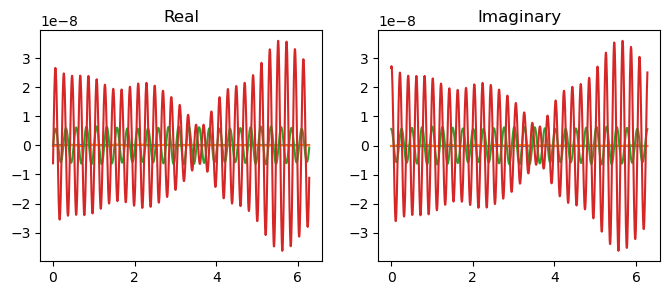

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             4.467e-09      
Worst:          inf             3.622e-08      
Std             nan             7.112e-09      
Total imaginary component
0.0

solve_integration_factor: average p_eff: 2.050785265507004
solve_integration_factor: average f_eff: 0.3440665737407185
integral_mode is fft
Batch fft time(s): 0.0060558319091796875
Difference


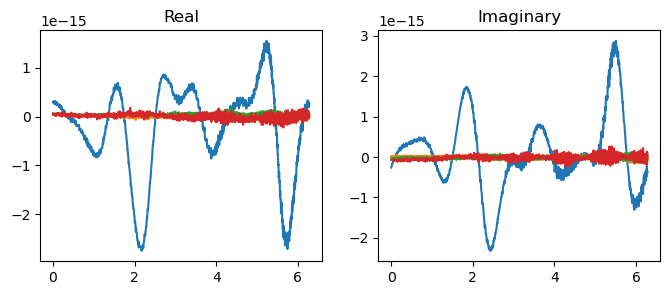

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             2.053e-16      
Worst:          inf             2.748e-15      
Std             nan             4.455e-16      
Total imaginary component
0.0

solve_integration_factor: average p_eff: 2.050785265507004
solve_integration_factor: average f_eff: 0.3440665737407185
integral_mode is spline
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
Batch spline time(s): 0.020698070526123047
Difference


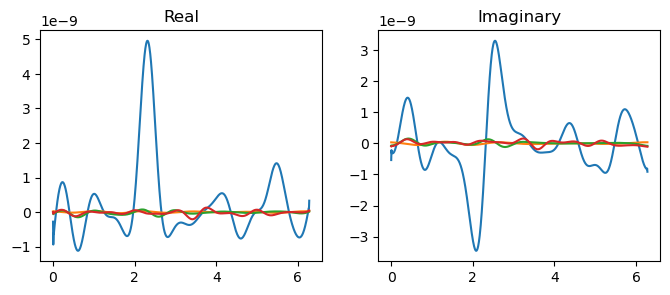

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             2.005e-10      
Worst:          inf             4.961e-09      
Std             nan             5.576e-10      
Total imaginary component
0.0

solve_integration_factor: average p_eff: 2.050785265507004
solve_integration_factor: average f_eff: 0.3440665737407185
integral_mode is spline
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
Batch double-spline time(s): 0.015006780624389648
Difference


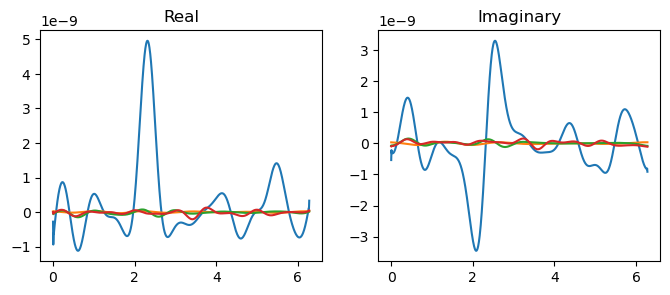

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             2.005e-10      
Worst:          inf             4.961e-09      
Std             nan             5.576e-10      
Total imaginary component
0.0

solve_integration_factor: average p_eff: 18.032865987462202
solve_integration_factor: average f_eff: 2.3844876748878807
Modes: ['asymptotic', 'spline', 'double_spline', 'spline']
solve_integration_factor: not all components use the same integral_mode. Solving each component individially
solve_integration_factor: average p_eff: 50.0012500078127
solve_integration_factor: average f_eff: 3.320457684068665
integral_mode is asymptotic
solve_integration_factor: average p_eff: 1.0635444099733649
solve_integration_factor: average f_eff: 0.07612078118881047
integral_mode is spline
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
solve_integration_factor: average p_eff: 20.0031251220

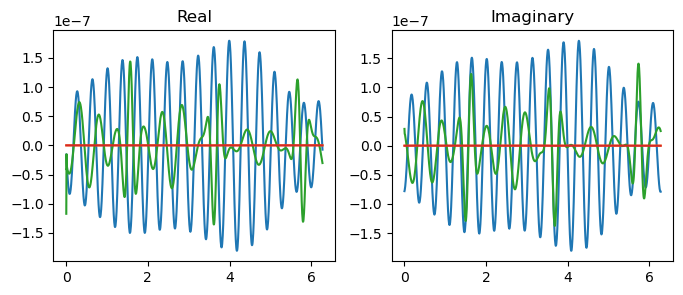

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             2.978e-08      
Worst:          inf             1.808e-07      
Std             nan             4.467e-08      
Total imaginary component
0.0



In [4]:
print('Testing general integrating factor')
# By trying different amplitudes above, the theeshold of 
# instability seems to be 17.
start_time = time.time()
a = 100*np.array([5*np.e**(2j*points),
              np.e**(1j*points), 
              np.e**(3j*points), 
              np.e**(4j*points)], dtype = np.complex128)+0.5
b = 1
RHS = a*test1.content+b*dphi_test1.content
guess_batch_asymp = solve_integration_factor(a,b,RHS,integral_mode='asymptotic')
print("Batch asymptotic time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_batch_asymp),test1)

# By trying different amplitudes above, the theeshold of 
# instability seems to be 17.
start_time = time.time()
a = 1*np.array([5*np.e**(2j*points),
              np.e**(1j*points), 
              np.e**(3j*points), 
              np.e**(4j*points)], dtype = np.complex128)+0.5
b = 1
RHS = a*test1.content+b*dphi_test1.content
guess_batch_asymp = solve_integration_factor(a,b,RHS,integral_mode='fft', fft_max_freq=50)
print("Batch fft time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_batch_asymp),test1)

# By trying different amplitudes above, the theeshold of 
# instability seems to be 17.
start_time = time.time()
RHS = a*test1.content+b*dphi_test1.content
guess_batch_asymp = solve_integration_factor(a,b,RHS,integral_mode='spline')
print("Batch spline time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_batch_asymp),test1)

start_time = time.time()
RHS = a*test1.content+b*dphi_test1.content
guess_batch_int = solve_integration_factor(a,b,RHS,integral_mode='spline')
print("Batch double-spline time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_batch_int),test1)

start_time = time.time()
a = np.array([50*np.e**(2j*points),
              np.e**(1j*points), 
              20*np.e**(3j*points), 
              np.e**(4j*points)], dtype = np.complex128)+0.5
b = 1
RHS = a*test1.content+b*dphi_test1.content
guess_ind = solve_integration_factor(a,b,RHS)
print("individual time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_ind),test1)



Testing solve_dphi_iota_dchi
Simpson mode
solve_integration_factor: average p_eff: 0.7260214809570331
solve_integration_factor: average f_eff: 0.4296680938735775
integral_mode is simpson
simpson
int_p
[[0.+0.00000000e+00j 0.-6.84259125e-03j 0.-1.36851825e-02j ...
  0.-6.82890607e+00j 0.-6.83574866e+00j 0.-6.84259125e+00j]
 [0.+0.00000000e+00j 0.-2.28086375e-03j 0.-4.56172750e-03j ...
  0.-2.27630202e+00j 0.-2.27858289e+00j 0.-2.28086375e+00j]
 [0.+0.00000000e+00j 0.+2.28086375e-03j 0.+4.56172750e-03j ...
  0.+2.27630202e+00j 0.+2.27858289e+00j 0.+2.28086375e+00j]
 [0.+0.00000000e+00j 0.+6.84259125e-03j 0.+1.36851825e-02j ...
  0.+6.82890607e+00j 0.+6.83574866e+00j 0.+6.84259125e+00j]]
f_looped
[[1.31113955+1.04732003j 1.31794397+1.02102418j 1.32402296+0.99436732j
  ... 1.29536422+1.09878443j 1.30361205+1.07324377j
  1.31113955+1.04732003j]
 [0.6344482 +0.57148388j 0.62711985+0.57030827j 0.61949842+0.56890532j
  ... 0.64822215+0.57315028j 0.64148254+0.57243142j
  0.6344482 +0.57148388j]

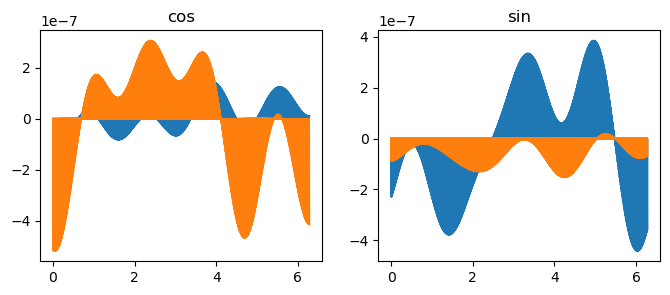

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             3.382e-08      
Worst:          inf             2.59e-07       
Std             nan             5.544e-08      
Total imaginary component
0.0

Spline mode
solve_integration_factor: average p_eff: 0.7260214809570331
solve_integration_factor: average f_eff: 0.4296680938735775
integral_mode is spline
int_p
[[0.+0.00000000e+00j 0.-6.84259125e-03j 0.-1.36851825e-02j ...
  0.-6.82890607e+00j 0.-6.83574866e+00j 0.-6.84259125e+00j]
 [0.+0.00000000e+00j 0.-2.28086375e-03j 0.-4.56172750e-03j ...
  0.-2.27630202e+00j 0.-2.27858289e+00j 0.-2.28086375e+00j]
 [0.+0.00000000e+00j 0.+2.28086375e-03j 0.+4.56172750e-03j ...
  0.+2.27630202e+00j 0.+2.27858289e+00j 0.+2.28086375e+00j]
 [0.+0.00000000e+00j 0.+6.84259125e-03j 0.+1.36851825e-02j ...
  0.+6.82890607e+00j 0.+6.83574866e+00j 0.+6.84259125e+00j]]
f_looped
[[1.31113955+1.04732003j 1.31794397+1.02102418j 1.32402296+0.99436

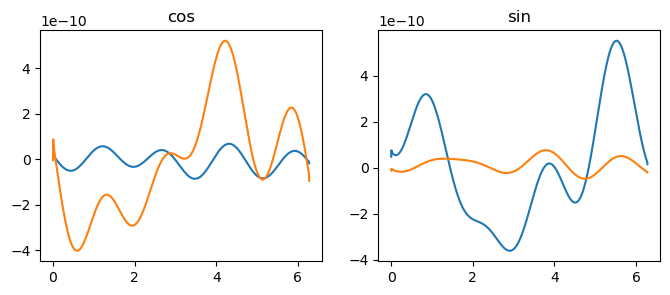

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             5.747e-11      
Worst:          inf             2.607e-10      
Std             nan             6.463e-11      
Total imaginary component
0.0



In [8]:
print('Testing solve_dphi_iota_dchi')

print('Simpson mode')
test1_guess = solve_dphi_iota_dchi(iota, (dphi_test1+iota*dchi_test1).content, integral_mode = 'simpson')
compare_chiphifunc(ChiPhiFunc(test1_guess),test1)


print('Spline mode')
test1_guess = solve_dphi_iota_dchi(iota, (dphi_test1+iota*dchi_test1).content)
compare_chiphifunc(ChiPhiFunc(test1_guess),test1)

# Testing $(A+B\partial_\chi)y=b$ linear system solver

In [43]:
# Generating coefficients
coef_A = rand_ChiPhiFunc(2)
coef_B = rand_ChiPhiFunc(2)
coef_C = rand_ChiPhiFunc(3)

## Odd with center as free component

Difference


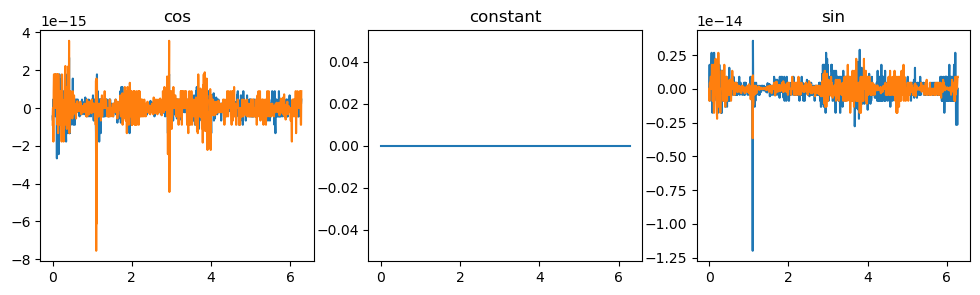

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            8.415e-16       1.443e-16      
Worst:          2.473e-13       5.551e-15      
Std             7.802e-15       2.421e-16      
Total imaginary component
0.0



In [52]:
test_Y = rand_ChiPhiFunc(5)
RHS = coef_A*test_Y+coef_B*test_Y.dchi()

O_matrices, O_einv, vector_free_coef = \
    ChiPhiFunc.get_O_O_einv_from_A_B(coef_A, coef_B, 2, 4)

guess_Y_content = (np.einsum('ijk,jk->ik',O_einv,RHS.content) + test_Y[0].content[0] * vector_free_coef)
compare_chiphifunc(ChiPhiFunc(guess_Y_content), test_Y)

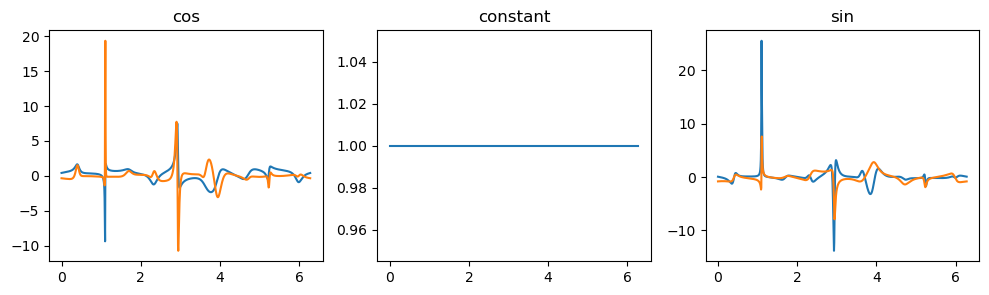

In [54]:
ChiPhiFunc(vector_free_coef).display_content()

## Even with $m=+1$ as free component

Difference


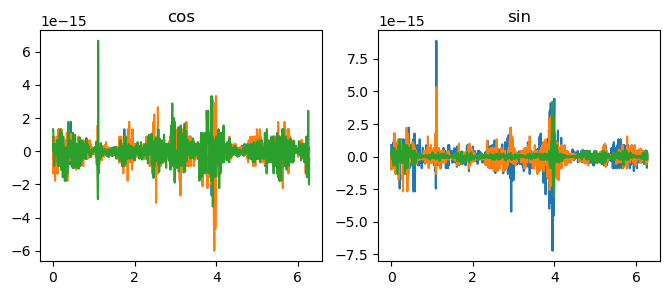

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            3.853e-16       1.785e-16      
Worst:          1.823e-13       5.107e-15      
Std             3.159e-15       2.962e-16      
Total imaginary component
0.0



In [55]:
test_Y = rand_ChiPhiFunc(6)
RHS = coef_A*test_Y+coef_B*test_Y.dchi()

O_matrices, O_einv, vector_free_coef = \
    ChiPhiFunc.get_O_O_einv_from_A_B(coef_A, coef_B, 3, 5)

guess_Y_content = (np.einsum('ijk,jk->ik',O_einv,RHS.content) + test_Y[1].content[0] * vector_free_coef)
compare_chiphifunc(ChiPhiFunc(guess_Y_content), test_Y)

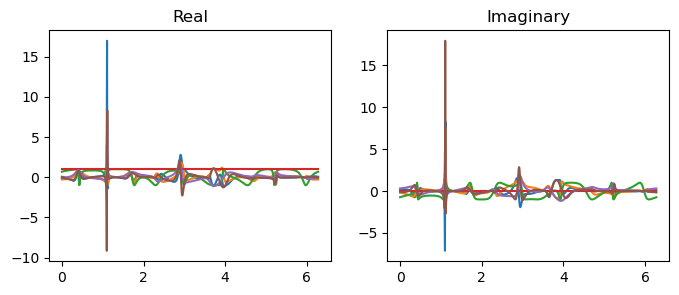

In [57]:
ChiPhiFunc(vector_free_coef).display_content(fourier_mode=False)

## Even with $Y^c_{n,1}$ as the free component

In [46]:
test_Y = rand_ChiPhiFunc(6)
RHS = coef_A*test_Y+coef_B*test_Y.dchi()

i_1p = 3
i_1n = 2

O_matrices, O_einv, vector_free_coef = \
    ChiPhiFunc.get_O_O_einv_from_A_B(coef_A, coef_B, i_1p, 5)


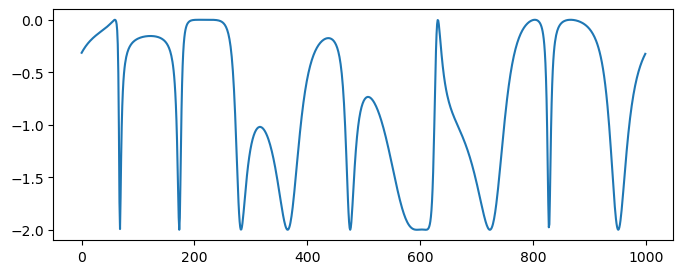

In [47]:
plt.plot(vector_free_coef[i_1n]-1)


In [48]:

vec_free = (np.einsum('ik,ik->k',O_einv[i_1n],RHS.content) + (test_Y[1]+test_Y[-1]).content[0])/(vector_free_coef[i_1n]-1)



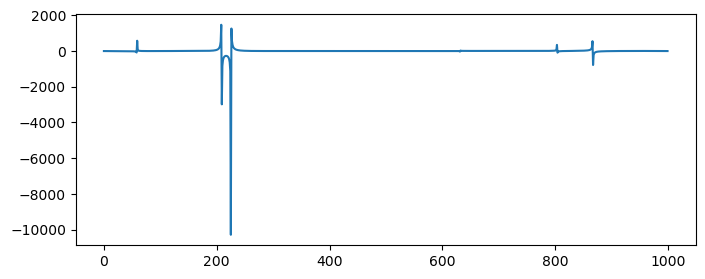

In [49]:
plt.plot(vec_free)

In [ ]:

guess_Y_content = (np.einsum('ijk,jk->ik',O_einv,RHS.content) + test_Y[1].content[0] * vector_free_coef)
compare_chiphifunc(ChiPhiFunc(guess_Y_content), test_Y)